In [1]:
import os
import sys
import gin
import numpy as np
import pandas as pd
module_path = os.path.abspath(os.path.join('..'))
if module_path not in sys.path:
    sys.path.append(module_path)
    
from IPython.core.display import clear_output, display

import matplotlib.pyplot as plt

%matplotlib inline
%load_ext autoreload
%autoreload 2


In [2]:
from prepare import parse

csv_params = {
"sep": '\s+',
#"nrows": 15000,
"encoding": 'utf-8',
"names": ['event',  'x', 'y', 'z', 'station', 'track', 'px', 'py', 'pz', 'X0', 'Y0', 'Z0']
}

stations_constraints = {
    0: {'x': [-166.6, 166.6], 'y': [-166.6, 166.6], 'z': [-423.5, 423.5]},
    1: {'x': [-166.6, 166.6], 'y': [-166.6, 166.6], 'z': [-423.5, 423.5]},
    2: {'x': [-166.6, 166.6], 'y': [-166.6, 166.6], 'z': [-423.5, 423.5]},
}

In [127]:
from ariadne.transformations import Compose, ConstraintsNormalize, ToCylindrical, DropSpinningTracks, DropShort, DropEmpty

events = parse("/zfs/hybrilit.jinr.ru/user/p/pgonchar/data/bes3/events/3.txt", csv_params=csv_params, events_quantity=':')
#events = parse("/Users/egor/prog/dubna/models2606/zfs/hybrilit.jinr.ru/user/p/pgonchar/data/bes3/events/3.txt", csv_params=csv_params, events_quantity=':')
events = next(events)[0]
n_events = 300
events_to_analyze = events[events.event < n_events]

global_transformer = Compose([
        DropSpinningTracks(),
        DropShort(num_stations=3),
        DropEmpty()
    ])

events_to_analyze = global_transformer(events_to_analyze)


TrackNet eval methods

In [136]:
import torch

from ariadne.graph_net.graph_utils.graph_prepare_utils import to_pandas_graph_from_df

from ariadne.utils.model import get_checkpoint_path, weights_update
from ariadne.tracknet_v2.model import TrackNETv2
from ariadne.tracknet_v2_1.model import TrackNetClassifier
from ariadne.transformations import Compose, ConstraintsNormalize, ToCylindrical, DropSpinningTracks, DropShort

from torch.nn import functional as F

import faiss


def load_tracknet_models():
    tracknet_input_features=3
    tracknet_conv_features=32
    
    tracknet_ckpt_path_dict = {'model_dir': '/zfs/hybrilit.jinr.ru/user/n/nuvard/ariadne/lightning_logs/TrackNETv2', 
                           'version': 'version_22', 'checkpoint': 'latest'}
    classifier_ckpt_path_dict = {'model_dir': '/zfs/hybrilit.jinr.ru/user/n/nuvard/ariadne/lightning_logs/TrackNetClassifier', 
                             'version': 'version_108', 'checkpoint': 'latest'}
#     tracknet_ckpt_path_dict = {'model_dir': '/Users/egor/prog/dubna/models2606/zfs 2/hybrilit.jinr.ru/user/n/nuvard/ariadne/lightning_logs/TrackNETv2', 
#                            'version': 'version_22', 'checkpoint': 'latest'}
#     classifier_ckpt_path_dict = {'model_dir': '/Users/egor/prog/dubna/models2606/zfs 3/hybrilit.jinr.ru/user/n/nuvard/ariadne/lightning_logs/TrackNetClassifier', 
#                              'version': 'version_108', 'checkpoint': 'latest'}

    path_to_tracknet_ckpt = get_checkpoint_path(**tracknet_ckpt_path_dict)
    path_to_classifier_ckpt = get_checkpoint_path(**classifier_ckpt_path_dict)

    model = weights_update(model=TrackNETv2(input_features=tracknet_input_features,
                                        conv_features=tracknet_conv_features,
                                        rnn_type='gru',
                                        batch_first=True),
                       checkpoint=torch.load(path_to_tracknet_ckpt, map_location=torch.device(DEVICE)))
    model.eval()
    
    model.to(DEVICE)
    class_model = weights_update(model=TrackNetClassifier(coord_size=2),
                             checkpoint=torch.load(path_to_classifier_ckpt, map_location=torch.device(DEVICE)))
    class_model.eval()
    class_model.to(DEVICE)
    
    return model, class_model

DEVICE = 'cuda' if torch.cuda.is_available() else 'cpu'
NUM_COMPONENTS = 2
#NUM_POINTS_TO_SEARCH = 1
NUM_POINTS_TO_SEARCH = 2
# for event 187 there are only 1 point at the last station
# what do we do?

SUFX = ['_p', '_c']
COLS = ['z', 'phi']
_constraints = {'r': [80., 167.], 'phi': [-3.15, 3.15], 'z': [-423.5, 423.5]}
_columns=('r', 'phi', 'z')

threshold = 0.5

tracknet_transformer = Compose([
        DropSpinningTracks(),
        DropShort(num_stations=3),
        ToCylindrical(drop_old=True),
        ConstraintsNormalize(columns=_columns, constraints=_constraints)
    ])

def build_index(target_df):
    cont = np.ascontiguousarray(target_df[COLS].values)
    return store_in_index(cont, num_components=2)

def search(points, index):
    cont = np.ascontiguousarray(points[COLS].values)
    return search_in_index(cont, index, 10)

def to_cart(df):
    graph=to_pandas_graph_from_df(df,SUFX, save_index=False)
    seeds = graph[(graph.station_p == 0) & (graph.station_c == 1)]
    target = df[df.station == 2]
    return seeds, target.reset_index(drop=True)

def seeds_to_input(seeds_df):
    return seeds_df[['z_p', 'phi_p', 'r_p', 'z_c', 'phi_c', 'r_c']].values.reshape((-1, 2, 3))

def preprocess_one_event(event_df):
    event_df = event_df[['event','x','y','z','station','track']]
    
    try:
        event_df = tracknet_transformer(event_df)
    except AssertionError as err:
        print("ASS error %r" % err)
        return None
    event_df.rename(columns={'index': 'index_old'}, inplace=True)
    seeds_unsorted, target = to_cart(event_df)

    batch = seeds_to_input(seeds_unsorted)
    chunk_data_len = torch.tensor(np.full(len(batch), 2), dtype=torch.int64).to(DEVICE)
    
    return seeds_unsorted, target, batch, chunk_data_len


def faiss_seeds_for_class(seeds, target, pred):
    index = faiss.IndexFlatL2(2)
    db = np.ascontiguousarray(target[['z','phi']].values).astype('float32')
    index.add(db)
    
    what_search = np.ascontiguousarray(pred[:,-1,:2].astype('float32'))
    d, idx = index.search(what_search, NUM_POINTS_TO_SEARCH)

    return d, idx

def in_ellipse_check(pnts_x, ellipse_x, ellipse_dist_w, pnts_y, ellipse_y, ellipse_dist_h):
    return (np.square(pnts_x - ellipse_x) / np.square(ellipse_dist_w) + np.square(pnts_y - ellipse_y) / np.square(ellipse_dist_h)) <= 1

def filter_by_ellipse(seeds, target, pred, pred_gru):

    dist, idx = faiss_seeds_for_class(seeds, target, pred)
    idx = idx.reshape(-1)

    seeds[['pred_x', 'pred_y', 'pred_w', 'pred_h']] = pred[:, -1, :]

    selected_pnts = target.iloc[idx]
    new_idx = seeds.index.repeat(NUM_POINTS_TO_SEARCH)
    seeds_for_pnts = seeds.loc[new_idx]

    ellipse_x = seeds_for_pnts['pred_x'].values
    ellipse_y = seeds_for_pnts['pred_y'].values
    ellipse_dist_w = seeds_for_pnts['pred_w'].values
    ellipse_dist_h = seeds_for_pnts['pred_h'].values
    
    pnts_x = selected_pnts[['z']].values.T[0]
    pnts_y = selected_pnts[['phi']].values.T[0]
    
    selected_pnts['in_ellipse'] = in_ellipse_check(pnts_x, ellipse_x, ellipse_dist_w, pnts_y, ellipse_y, ellipse_dist_h)
    
    seeds_for_pnts['index_next'] = selected_pnts.index_old.values
    seeds_for_pnts['in_ellipse'] = selected_pnts.in_ellipse.values
    seeds_for_pnts['z_next'] = selected_pnts.z.values
    seeds_for_pnts['phi_next'] = selected_pnts.phi.values

    seeds_for_pnts.track = np.logical_and(seeds_for_pnts.track.values, (seeds_for_pnts.track_c.values == selected_pnts.track.values))
    
    gru_for_pnts = np.repeat(pred_gru, NUM_POINTS_TO_SEARCH, 0)

    return seeds_for_pnts[seeds_for_pnts.in_ellipse.values], gru_for_pnts[seeds_for_pnts.in_ellipse.values]
    
def final_class_pred(class_model, filtered_gru, filtered, threshold):
    class_pred = F.sigmoid(class_model(torch.tensor(filtered_gru[:, -1, :]).to(DEVICE), 
                                       torch.tensor(filtered[['z_next', 'phi_next']].values).to(DEVICE)))
    filtered['class_pred_score'] = (class_pred).detach().cpu().numpy()
    filtered['track_pred'] = filtered.class_pred_score > threshold
    return filtered


def run_tracknet_eval(input_, model):    
    seeds, target, batch, chunk_data_len = input_
    model, class_model = model
    
    pred, pred_gru = model(torch.tensor(batch).to(DEVICE), chunk_data_len, return_gru_states=True)
    pred = pred.cpu().detach().numpy()
    pred_gru = pred_gru.cpu().detach().numpy()

    filtered, filtered_gru = filter_by_ellipse(seeds, target, pred, pred_gru)    
    final = final_class_pred(class_model, filtered_gru, filtered, threshold)
    
    result = final[['track_pred']]
    result['hit_0_id'] = final[['index_old_p']]
    result['hit_1_id'] = final[['index_old_c']]
    result['hit_2_id'] = final[['index_next']]
    
    return result

In [137]:
class Appender:
    def __init__(self, columns):
        self.result_dict = {col:[] for col in columns}
    
    def append(self, dict_with_vals):
        for key, value in dict_with_vals.items():
            self.result_dict[key].append(value)

    def to_df(self):
        return pd.DataFrame.from_dict(self.result_dict)
    

In [138]:
from itertools import chain
import traceback
from time import sleep
from tqdm import tqdm



def test_model(events, model_load_func,model_preprocess_func, model_run_func):
    COLUMNS=['event_id', 'track_pred', 'hit_0_id', 'hit_1_id', 'hit_2_id']
    result_dict={col:[] for col in COLUMNS}
    
    loaded_model = model_load_func()
    #model_result_df = pd.DataFrame()
    #vals_arr = np.array()
    with tqdm(total=events.event.nunique(), file=sys.stdout) as pbar:
        for ev_id, event_df in events.groupby('event'): 
            pbar.set_description('processed: %d' % (ev_id))
            pbar.update(1)
            
            try:
                preprocess_result = model_preprocess_func(event_df)
                if preprocess_result is None:
                    continue
            except KeyboardInterrupt as ex:
                break
            except:
                error_message = traceback.format_exc()
                
                print(f"got exception for preprocessing:\n message={error_message} \n\
                        on \nevent_id={ev_id}")
                continue
            
            try:
                model_run_df = model_run_func(preprocess_result, loaded_model)
            except KeyboardInterrupt as ex:
                break
            except:
                error_message = traceback.format_exc()
                print(f"got exception for model run:\n message={error_message} \n\
                        on \nevent_id={ev_id}")
                continue
    
            model_run_df['event_id'] = ev_id
    
            columns_for_metrics = ['event_id', 'track_pred', 'hit_0_id', 'hit_1_id', 'hit_2_id']
            for col in columns_for_metrics:
                assert col in model_run_df.columns, f"{col} not in {model_run_df.columns}"
            
            for col in COLUMNS:
                result_dict[col].extend(model_run_df[col].values)
            #model_result_df = model_result_df.append(model_run_df[columns_for_metrics], ignore_index=True)
    model_result_df = pd.DataFrame.from_dict(result_dict)[COLUMNS]
    return model_result_df

def get_impulse_for_ghost(pax, general, label):
    pax = pax[label]

    if pax.empty:
        pax_mean = general
    else:
        pax_mean = pax.mean()
    assert(np.abs(pax_mean) > 0)
    return pax_mean

def build_model_results(model_name, events, load_tracknet_models, preprocess_one_event, run_tracknet_eval):
    
    print(f"testing model '{model_name}'...")
    result_df = test_model(events, load_tracknet_models, preprocess_one_event, run_tracknet_eval)
    
    print(f"building result '{model_name}'...")
    total_events = 0

    total_tracks = 0
    total_tracks_true = 0
    total_events_true = 0
    total_hits = 0
    total_hits_true = 0

    COLUMNS_DF = ['event', 'track', 'hit_0_id', 'hit_1_id', 'hit_2_id', 'px', 'py', 'pz', 'pred', 'multiplicity']
    all_tracks_df = pd.DataFrame(columns=COLUMNS_DF)

    all_events_df = pd.DataFrame(columns=['event','multiplicity','pred', 'time'])
    
    with tqdm(total=events.event.nunique(), file=sys.stdout) as pbar:
        for idx, event in events.groupby('event'):
            pbar.set_description('processed: %d' % (idx))
            pbar.update(1)

            ev_id_real = event.event.values[0]

            px_mean_general = event[event.track != -1].px.min()
            py_mean_general = event[event.track != -1].py.min()
            pz_mean_general = event[event.track != -1].pz.min()

            hits_in_event = set()

            tracks_in_event = event[event.track != -1].track.nunique()
            
            true_tracks_arr = Appender(COLUMNS_DF)
            
            for tr_id, track in event.groupby('track'):
                if tr_id != -1:
                    index_values = track.index.values
                    assert len(index_values) >= 3, f"track len <3 for event {idx} tr_id {tr_id}"
                    px_py_pz = track[['px', 'py', 'pz']].values[0]
                    hits_in_event.update(index_values)
                    
                    true_tracks_arr.append({
                        'event':int(ev_id_real),
                        'track':int(tr_id),
                        'hit_0_id':int(index_values[0]),
                        'hit_1_id':int(index_values[1] if len(index_values) > 1 else -1),
                        'hit_2_id':int(index_values[2] if len(index_values) > 2 else -1),
                        'px':px_py_pz[0],
                        'py':px_py_pz[1],
                        'pz':px_py_pz[2],
                        'pred':int(0),
                        'multiplicity':int(tracks_in_event)
                    })
            
            all_tracks_df = pd.concat([all_tracks_df, true_tracks_arr.to_df()], ignore_index=True)

            total_tracks += tracks_in_event
            total_hits += len(hits_in_event)
            total_events += 1

            if ev_id_real not in result_df.event_id:
                continue

            reco_tracks=0
            edge_ind_pred = result_df[result_df.event_id == ev_id_real][result_df.track_pred][['hit_0_id', 'hit_1_id', 'hit_2_id']].values
            ghosts = Appender(COLUMNS_DF)

            for track_cand in edge_ind_pred:
                atdv = all_tracks_df
                match = ((atdv.hit_0_id == track_cand[0]) & 
                         (atdv.hit_1_id == track_cand[1]) & 
                         (atdv.hit_2_id == track_cand[2]))

                matched_track = all_tracks_df[match]
                assert len(matched_track) < 2
                if matched_track.empty:
                    pax = event.loc[track_cand]
                    pax = pax[pax.track != -1]
                    if pax.empty:
                        px, py, pz = px_mean_general, py_mean_general, pz_mean_general
                    else:
                        px, py, pz = pax[['px', 'py', 'pz']].values[0]

                    ghosts.append({
                        'event':int(ev_id_real),
                        'track':-1,
                        'hit_0_id':int(track_cand[0]),
                        'hit_1_id':int(track_cand[1]),
                        'hit_2_id':int(track_cand[2]),
                        'px':px,
                        'py':py,
                        'pz':pz,
                        'pred':-1,                
                        'multiplicity':int(tracks_in_event)
                    })
                else:            
                    all_tracks_df.loc[match, 'pred'] = 1 
                    total_tracks_true += 1
                    reco_tracks += 1
            
            all_tracks_df = pd.concat([all_tracks_df, ghosts.to_df()], ignore_index=True)
            
            hits_pred = set(chain.from_iterable(edge_ind_pred))

            found_hits = hits_pred.intersection(hits_in_event)
            total_hits_true += len(found_hits)

            preddd=0

            if reco_tracks == tracks_in_event:
                total_events_true += 1
                preddd=1

            all_events_df = all_events_df.append({
                'event':int(ev_id_real),
                'multiplicity':int(tracks_in_event),
                'pred':preddd,
                'time':0
            }, ignore_index=True)

    all_tracks_df = all_tracks_df.astype({
        'event': 'int32',
        'track': 'int32',
        'hit_0_id': 'int32',
        'hit_1_id': 'int32',
        'hit_2_id': 'int32',
        'px': 'float32',
        'py': 'float32',    
        'pz': 'float32',
        'pred':'int32',
        'multiplicity':'int32'
    })
        
    all_events_df = all_events_df.astype({
        'event': 'int32',
        'pred':'int32',
        'multiplicity':'int32',
        'time':'int32'
    })
    
    print(f"Results for model '{model_name}'")
    print("Total track efficiency: %.04f" % (total_tracks_true / total_tracks))
    print("Total hit efficiency: %.04f" % (total_hits_true / total_hits))
    print("Total event efficiency: %.04f" % (total_events_true / total_events))
    #print("Mean event processing speed: %.02f" % (all_events_df.time.mean()))

    return all_tracks_df, all_events_df, total_events, total_tracks, total_tracks_true, total_events_true, total_hits, total_hits_true,

#test_model(events, load_tracknet_models, preprocess_one_event, run_tracknet_eval)
    

In [63]:
p = test_model(events[events.event < 15], load_tracknet_models, preprocess_one_event, run_tracknet_eval)
p
#a = build_model_results("TrackNetV2.1", events[events.event < 10], load_tracknet_models, preprocess_one_event, run_tracknet_eval)
#a

processed: 13: 100%|██████████| 1/1 [00:00<00:00, 21.63it/s]


,event_id,track_pred,hit_0_id,hit_1_id,hit_2_id
0,13,True,464,465,466
1,13,True,464,465,456
2,13,True,464,468,469
3,13,True,464,468,457
4,13,True,464,470,471
...,...,...,...,...,...
435,13,True,432,444,447
436,13,True,432,445,473
437,13,True,432,445,463
438,13,True,432,446,473


In [139]:
res_tracknet = build_model_results("TrackNetV2.1", events_to_analyze, load_tracknet_models, preprocess_one_event, run_tracknet_eval)

testing model 'TrackNetV2.1'...
processed: 299: 100%|██████████| 261/261 [00:12<00:00, 21.50it/s]
building result 'TrackNetV2.1'...
processed: 299: 100%|██████████| 261/261 [00:06<00:00, 37.90it/s]
Results for model 'TrackNetV2.1'
Total track efficiency: 0.7941
Total hit efficiency: 0.8192
Total event efficiency: 0.4636


In [123]:
events_to_analyze

,event,x,y,z,station,track,px,py,pz,X0,Y0,Z0,index
0,0,-80.90526,-10.27410,-11.94216,0,11,-0.193425,-0.004823,-0.029994,0.879332,-0.230192,0.127600,8
1,0,-124.69720,-18.45198,-18.66805,1,11,-0.193425,-0.004823,-0.029994,0.879332,-0.230192,0.127600,9
2,0,-164.06280,-28.70505,-24.25757,2,11,-0.193425,-0.004823,-0.029994,0.879332,-0.230192,0.127600,10
3,0,70.23064,-41.45931,46.42090,0,22,0.342074,-0.229190,0.254322,0.879314,-0.230840,0.127388,11
4,0,108.82010,-63.62430,73.05208,1,22,0.342074,-0.229190,0.254322,0.879314,-0.230840,0.127388,12
...,...,...,...,...,...,...,...,...,...,...,...,...,...
152,3,-165.73760,16.48051,-158.49010,2,-1,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,140
153,3,-21.67592,-165.13850,-364.45410,2,-1,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,141
154,3,-21.67592,-165.13850,263.69210,2,-1,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,142
155,3,-21.67592,-165.13850,273.97970,2,-1,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,143


# GraphNet BES-III

In [140]:
from ariadne.graph_net.graph_utils.graph_prepare_utils import to_pandas_graph_from_df, get_pd_line_graph, \
    apply_nodes_restrictions, apply_edge_restriction, construct_output_graph
from ariadne.transformations import Compose, ConstraintsNormalize, ToCylindrical


suff_df = ('_p', '_c')
gin.bind_parameter('get_pd_line_graph.restrictions_0',(-0.2, 0.2))
gin.bind_parameter('get_pd_line_graph.restrictions_1', (-0.28, 0.28))
gin.bind_parameter('get_pd_line_graph.suffix_c', '_c')
gin.bind_parameter('get_pd_line_graph.suffix_p','_p')
gin.bind_parameter('get_pd_line_graph.spec_kwargs', {'suffix_c': '_c', 
                                                     'suffix_p':'_p', 
                                                     'axes':['r', 'phi', 'z']} )
_edge_restriction = 0.093

stations_constraints_g = {
    0: {'x': [-166.6, 166.6], 'y': [-166.6, 166.6], 'z': [-423.5, 423.5]},
    1: {'x': [-166.6, 166.6], 'y': [-166.6, 166.6], 'z': [-423.5, 423.5]},
    2: {'x': [-166.6, 166.6], 'y': [-166.6, 166.6], 'z': [-423.5, 423.5]},
}

from collections import namedtuple
GraphWithIndices = namedtuple('Graph', ['X', 'Ri', 'Ro', 'y', 'v1v2v3', 'ev_id' ])

transformer_g = Compose([
            ConstraintsNormalize(
                use_global_constraints=False,
                constraints=stations_constraints_g
            ),
            ToCylindrical(drop_old=True)
        ])


def construct_graph_with_indices(graph, v1v2v3, ev_id):
    return GraphWithIndices(graph.X, graph.Ri, graph.Ro, graph.y, v1v2v3, ev_id)


def get_graph(event):
    event = event[['event','x','y','z','station','track']]
    try:
        event = transformer_g(event)
    except AssertionError as err:
        print("ASS error %r" % err)
        return None

    G = to_pandas_graph_from_df(event, suffixes=suff_df, compute_is_true_track=True)
    nodes_t, edges_t = get_pd_line_graph(G, apply_nodes_restrictions)

    edges_filtered = apply_edge_restriction(edges_t, edge_restriction=_edge_restriction)
    graph = construct_output_graph(nodes_t, edges_filtered, ['y_p', 'y_c', 'z_p', 'z_c', 'z'],
                                     [np.pi, np.pi, 1., 1., 1.], 'edge_index_p', 'edge_index_c')
    ev_id = event.event.values[0]
    graph_with_inds = construct_graph_with_indices(graph,
                                                   edges_filtered[['from_ind', 'cur_ind', 'to_ind']].values, ev_id)
    return graph_with_inds

def load_graph_model():
    from ariadne.graph_net.model import GraphNet_v1
    import torch
    
    gin.bind_parameter('GraphNet_v1.input_dim', 5)
    gin.bind_parameter('GraphNet_v1.hidden_dim', 128)
    gin.bind_parameter('GraphNet_v1.n_iters', 1)
    
    def weights_update_g(model, checkpoint):
        model_dict = model.state_dict()    
        pretrained_dict =  checkpoint['state_dict']
        real_dict = {}
        for (k,v) in model_dict.items():
            needed_key = None
            for pretr_key in pretrained_dict:
                if k in pretr_key:
                    needed_key = pretr_key
                    break
            assert needed_key is not None, "key %s not in pretrained_dict %r!" % (k, pretrained_dict.keys())
            real_dict[k] = pretrained_dict[needed_key]
    
        model.load_state_dict(real_dict)
        model.eval()
        return model
    
    path_g = '/zfs/hybrilit.jinr.ru/user/g/gooldan/bes/ariadne/lightning_logs/version_63115/checkpoints/epoch=49.ckpt'
    #path_g = '/Users/egor/prog/dubna/models2606/zfs 4/hybrilit.jinr.ru/user/g/gooldan/bes/ariadne/lightning_logs/version_63115/checkpoints/epoch=49.ckpt'
    checkpoint_g = torch.load(path_g) if torch.cuda.is_available() else torch.load(path_g, map_location=torch.device('cpu'))
    model_g = weights_update(model=GraphNet_v1(), 
                       checkpoint=checkpoint_g)
    return model_g

from ariadne.graph_net.dataset import collate_fn
def eval_event(tgt_graph, model_g):
    batch_input, batch_target = collate_fn([tgt_graph])
    with torch.no_grad():
        y_pred = model_g(batch_input['inputs']).numpy().flatten() > 0.5
    
    eval_df = pd.DataFrame(columns=['track_pred', 'hit_0_id', 'hit_1_id', 'hit_2_id'])
    eval_df['track_pred'] = y_pred
    eval_df[['hit_0_id', 'hit_1_id', 'hit_2_id']] = tgt_graph.v1v2v3
    return eval_df


In [ ]:
res_graph = build_model_results("RDGraphNet", events_to_analyze, load_graph_model, get_graph, eval_event)
res_graph[0]

testing model 'RDGraphNet'...
processed: 261:  89%|████████▊ | 231/261 [00:17<00:02, 13.35it/s]

In [81]:
from scipy.interpolate import make_interp_spline, BSpline
from scipy import stats

MODES = {
    "RECALL":1,
    "PRECISION":2
}

def get_diagram_arr_linspace(all_real_hits, found_hits, start, end, num, col, mode):
    spac = np.linspace(start, end, num=num)
    step = (spac[1] - spac[0]) / 2
    arr = []
    spac_ret = []
    for i in range(len(spac)-1):
        beg = spac[i]
        end = spac[i+1]
        elems_real = all_real_hits[(all_real_hits[col] >= beg) & (all_real_hits[col] < end)]
        elems_pred = found_hits[(found_hits[col] >= beg) & (found_hits[col] < end)]
        #print(beg,end)
        #print(len(elems_pred), len(elems_real))
        if mode == MODES["RECALL"]:
            if elems_real.empty:
                arr.append(1.)
            else:
                arr.append(len(elems_pred) / len(elems_real))
        elif mode == MODES["PRECISION"]:
            if elems_pred.empty:
                arr.append(1.)
            else:
                reco_true = len(elems_pred[elems_pred.track != -1])
                arr.append(reco_true / len(elems_pred))
            
        else:
            raise NotImplemented

        spac_ret.append(spac[i] + step)
    
    return np.array(arr), np.array(spac_ret)


def get_diagram_for_boxplot(all_real_hits, found_hits, start, end, num, col, bin_array, int_mode, mode):
    y_vals, x_vals = get_diagram_arr_linspace(all_real_hits, found_hits, start, end, num, col, mode)

    np_y_vals = np.array(y_vals)
    bin_array = bin_array

    
    res_x_array = []
    res_box_data = []
    mean_box_array = []
    
    for i in range(len(bin_array)-1):
        beg = bin_array[i]
        end = bin_array[i+1]
        y_ind = np.where((x_vals>=beg) & (x_vals<end))
        y_vals_corr  = np_y_vals[y_ind]
        y_vals_corr = y_vals_corr[~np.isnan(y_vals_corr)]
        if len(y_vals_corr) == 0:
             continue
                
        #print(beg, end, i, stats.describe(y_vals_corr))
        #print(y_vals_corr)
#         if len(np.where(y_vals_corr < 1)) > 0:
#             print(y_vals_corr)
#             print(y_vals)
#             print(beg,end)
        
        res_box_data.append(y_vals_corr)
        delta = 0 if int_mode else (end-beg)/2
        res_x_array.append(beg + delta)
        mean_box_array.append(np.mean(y_vals_corr))

    return res_box_data, np.array(res_x_array), np.array(mean_box_array)
    #plt.boxplot(res_box_data, positions=bin_array)

def boxplot_style(bp):
    #for box in bp['boxes']:
            # change outline color
        #box.set( color='#7570b3', linewidth=2)
            # change fill color
        #box.set( facecolor = 'silver' )
    
    ## change color and linewidth of the whiskers
    #for whisker in bp['whiskers']:
    #    whisker.set(color='#7570b3', linewidth=2)
    #
    ### change color and linewidth of the caps
    #for cap in bp['caps']:
    #    cap.set(color='#7570b3', linewidth=2)
    #
    ### change color and linewidth of the medians
    #for median in bp['medians']:
    #    median.set(color='tab:red', linewidth=3, zorder=30)

    for median in bp['means']:
        median.set(color='tab:green', linewidth=3, ls='-', zorder=30)

In [120]:
from numpy import linalg as LA
import matplotlib as mpl
mpl.rcParams['figure.dpi'] = 300

def draw_for_col(ax, tracks_real, tracks_pred_true,
                 col, col_pretty, total_events, n_ticks=150, 
                 n_avg_ticks=-1, x_ticks=8,
                 custom_title=None,
                 ticks_custom=True,
                 with_boxplot=False,
                 int_mode=False, save_disk=True,
                 custom_draw_funcs=[],
                 diagram_func=None,
                 color_ax_ticks=False,
                 subtitle=None,
                 model_name="NO_MODEL_NAME",
                 graph_idx=0, total_indices=-1, spacing=-1,
                 color_line='tab:orange', color_box='red', mode=-1
                ):
    real_xticks_count = x_ticks
    
    color_ax_ticks = len(custom_draw_funcs) > 0 and color_ax_ticks
    n_avg_ticks = n_ticks // 5 if n_avg_ticks < 0 else n_avg_ticks
    
    delta = 1e-4 if not int_mode else 1
    
    start = tracks_real[tracks_real[col] > -np.inf][col].min()
    end = tracks_real[tracks_real[col] < np.inf][col].max()+delta

    initial, spac = get_diagram_arr_linspace(tracks_real, tracks_pred_true, start, end, n_ticks, col, mode)

    maxX = int(end) if int_mode else end
    ax.set_xlabel(col_pretty)
    ax.plot(spac, initial, alpha=0.0, lw=1)
    
    if not int_mode and ticks_custom:
        ax.set_xticks(np.linspace(start, maxX, x_ticks))
    else:
        ax.locator_params(axis='x', nbins=x_ticks)

    if diagram_func is None:
        ax.set_yticks(np.round(np.linspace(0, 1, 11), decimals=2))
    x_ticks = ax.get_xticks()
    
    if with_boxplot:
        old_ticks = x_ticks
        delta_x = (x_ticks[1] - x_ticks[0])/2

        diagram_func = get_diagram_for_boxplot if diagram_func is None else diagram_func
        
        box_data, ticks_x, mean_data = diagram_func(tracks_real, tracks_pred_true, start, end, 
                                                               n_ticks, col, x_ticks, int_mode, mode)
        if total_indices > 0:       
            
            width_tuned = delta_x * 2 / total_indices
            pos_tuned = ticks_x - delta_x
            spacings = width_tuned * 0.7
            width_real = width_tuned * 0.3
            
            ticks_x = pos_tuned + width_tuned * graph_idx + spacings/2 + width_real/2
            delta_x = width_real

        bp = ax.boxplot(box_data, positions=ticks_x, 
                    manage_ticks=False, meanline=True, showmeans=True,
                    widths=delta_x,patch_artist=True, sym='',zorder=3,boxprops=dict(facecolor=color_box))
        boxplot_style(bp)

        # mean line
        xnew = np.linspace(ticks_x.min(), ticks_x.max(), 500) 

        spl = make_interp_spline(ticks_x, mean_data, k=1)  # type: BSpline
        power_smooth = spl(xnew)
        ax.plot(xnew, power_smooth, ls='--', color=color_line, label=f'{model_name} mean track {subtitle}', lw=3, zorder=15)
        ax.set_xticks(old_ticks)
    
    if int_mode or not ticks_custom:
        ax.locator_params(axis='x', nbins=real_xticks_count)
    
    if diagram_func is None:
        ax.set_ylim((-0.05, 1.05))
    for draw_f in custom_draw_funcs:
        draw_f(ax)
    ####plt.locator_params(axis='y', nbins=16)
   

    #plt.tight_layout()
    #plt.rcParams['savefig.facecolor']='white'
    #os.makedirs('../output', exist_ok=True)
    #plt.savefig('../output/new_img_track_eff_%s_ev%r_t%d.png'%(col, total_events, n_ticks), dpi=300)
    #plt.show()

def to_recall(all_tracks_df):
    tracks_real = all_tracks_df[all_tracks_df.pred != -1]
    tracks_pred_true = all_tracks_df[all_tracks_df.pred == 1]
    return tracks_real, tracks_pred_true, MODES["RECALL"], "efficiency"

def to_precision(all_tracks_df):
    tracks_real = all_tracks_df[all_tracks_df.track != -1]
    tracks_pred_true = all_tracks_df[(all_tracks_df.pred == 1) | (all_tracks_df.pred == -1)]
    return tracks_real, tracks_pred_true, MODES["PRECISION"], "purity"

def plot_model_results(model_names, model_results_arr, mode_func):
        
    fig = plt.figure(figsize=(23,6), dpi=300)
    ax1, ax2, ax3 = fig.subplots(nrows=1, ncols=3, sharey='all')
#    ax1, ax2 = fig.subplots(nrows=1, ncols=2, sharey='all')
    total_models = len(model_names)
    colormap = plt.cm.tab10 #nipy_spectral, Set1,Paired   
    colors = [colormap(i) for i in np.linspace(0, 1, total_models*2)]
    
    for idx, (model_name, model_results) in enumerate(zip(model_names, model_results_arr)):

        all_tracks_df = model_results[0]
        
        all_tracks_df['pt'] = LA.norm(all_tracks_df[['px','py']].values, axis=1)
        all_tracks_df['cos_t'] = (all_tracks_df[['pz']].values/ LA.norm(all_tracks_df[['px','py','pz']].values, axis=1, keepdims=True))
        all_tracks_df['a_phi'] = np.arctan2(all_tracks_df[['px']].values, all_tracks_df[['py']].values)
        
        tracks_real, tracks_pred_true, mode, subtitle  = mode_func(all_tracks_df)

        color_box = colors[idx*2]        
        color_line = colors[idx*2 + 1]
        
        draw_for_col(ax1, tracks_real, tracks_pred_true, 'pt', '$pt$', n_events, 80, 
                 n_avg_ticks=48, x_ticks=16, ticks_custom=False, with_boxplot=True, model_name=model_name,
                    graph_idx=idx, total_indices=total_models, subtitle=subtitle,
                    color_line=color_line, color_box=color_box, mode=mode)
        
        
#         draw_for_col(ax1, tracks_real, tracks_pred_true, 'pt', '$pt$', n_events, 80, 
#                  n_avg_ticks=48, x_ticks=16, ticks_custom=False, with_boxplot=True, model_name=model_name,
#                     graph_idx=idx, total_indices=total_models,
#                     color_line=color_line, color_box=color_box, mode=MODES["RECALL"])
        
        #plt.ylabel('Track efficiency', fontsize=12)
        
        draw_for_col(ax2, tracks_real, tracks_pred_true, 'a_phi', '$a_\phi$',n_events, 350, 
                     n_avg_ticks=60, x_ticks=12, with_boxplot=True, model_name=model_name, 
                     graph_idx=idx, total_indices=total_models, subtitle=subtitle,
                     color_line=color_line, color_box=color_box, mode=mode)
        
        #enable on big dataset
        draw_for_col(ax3, tracks_real, tracks_pred_true,'cos_t', '$cos_t$',n_events, 350, 
                     n_avg_ticks=60,x_ticks=12, ticks_custom=False, with_boxplot=True, model_name=model_name,
                     graph_idx=idx, total_indices=total_models, subtitle=subtitle,
                     color_line=color_line, color_box=color_box, mode=mode)
    for ax in [ax1, ax2, ax3]:
        ax.grid()
        ax.legend()
    fig = plt.gcf()
    fig.suptitle(f"Models track {subtitle} on {model_results_arr[0][0].event.nunique()} events")
    plt.tight_layout()
    plt.rcParams['savefig.facecolor']='white'
    plt.show()
    pass


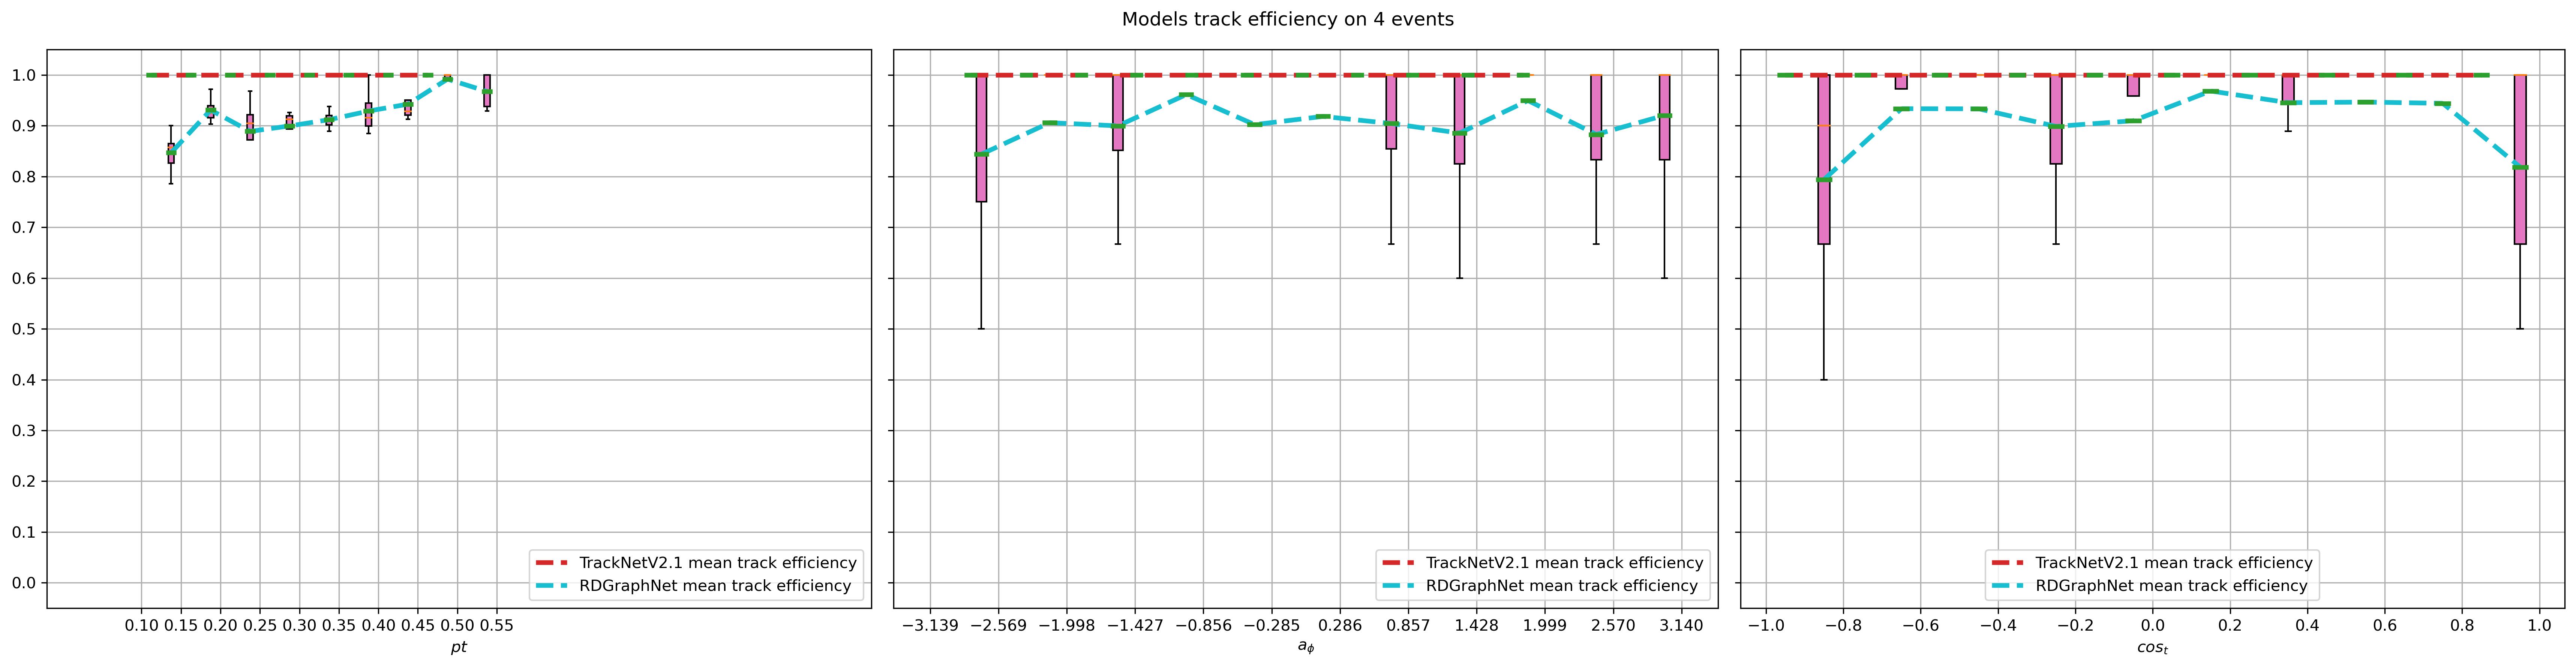

In [128]:
plot_model_results(["TrackNetV2.1", 'RDGraphNet'], [res_tracknet, res_graph], to_recall)

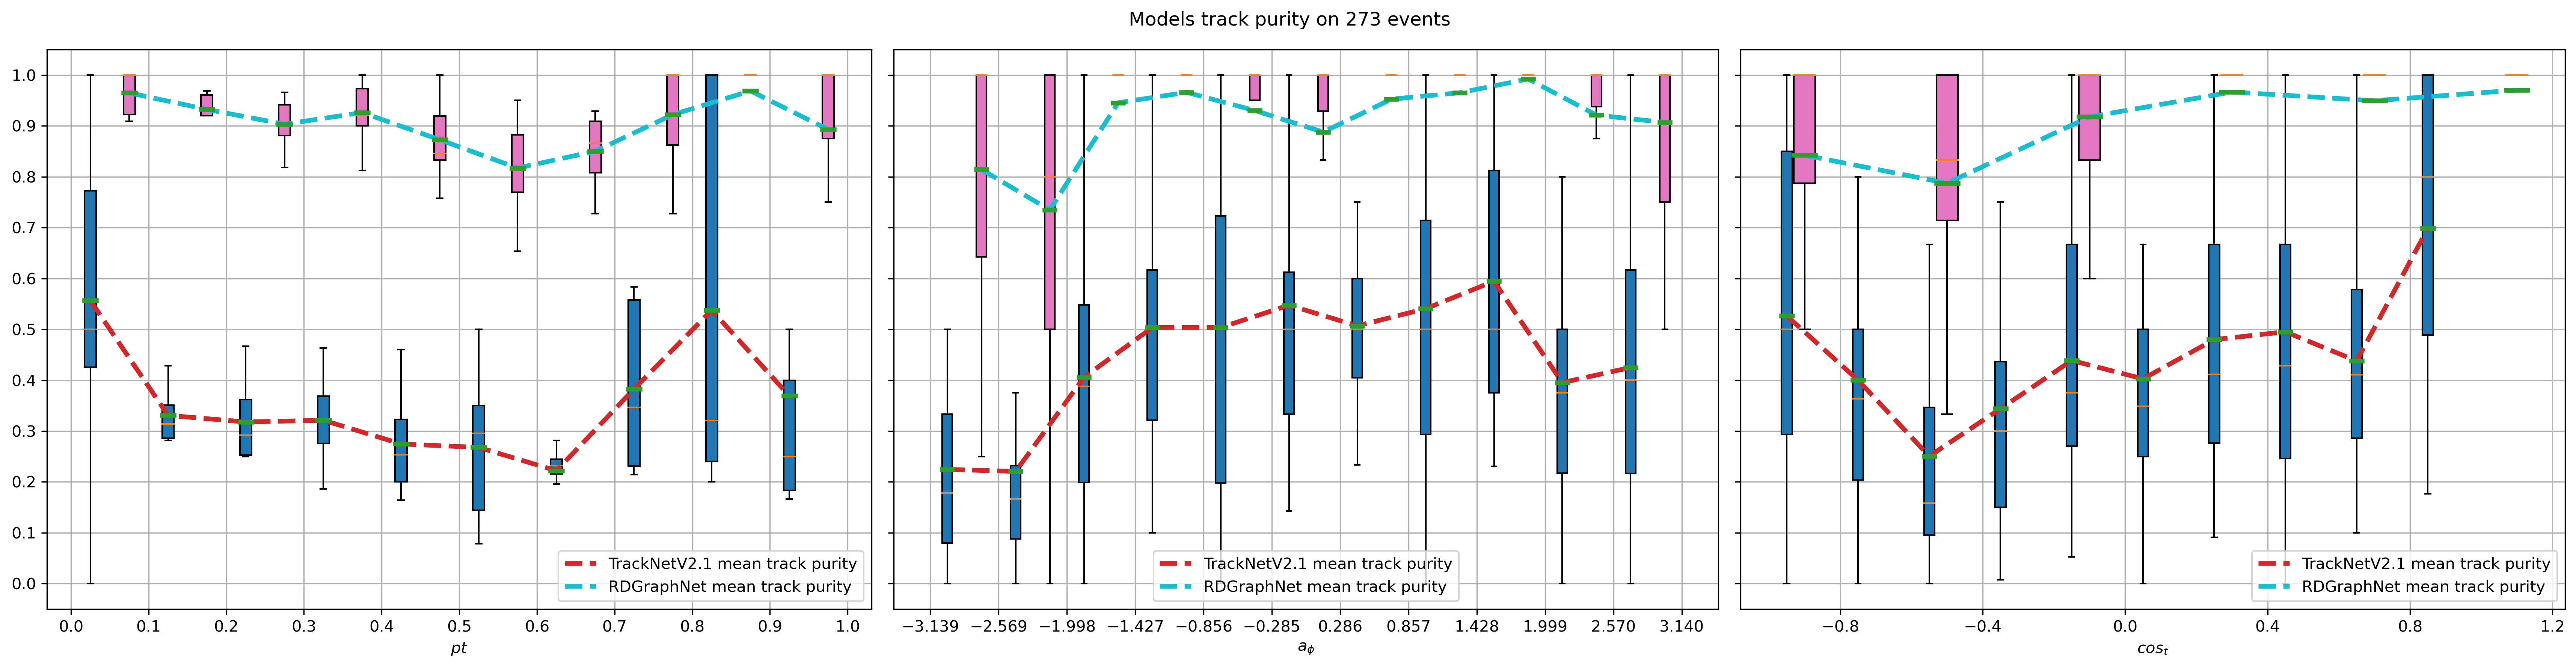

In [32]:
plot_model_results(["TrackNetV2.1", 'RDGraphNet'], [res_tracknet, res_graph], to_precision)